In [11]:
#Read DATA
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

def clean_my_df(df):

    numeric_features = df[numerical_data]
    categorical_features = df[categorical_data]

    for col_name in categorical_features.columns :
        categorical_features[col_name] = categorical_features[col_name].astype("category",
                                        categories=pd.unique(categorical_features[col_name].values.ravel()))
        
        data_oneHot = pd.get_dummies(categorical_features[col_name],prefix = col_name) # One hot encoding
        numeric_features = pd.concat([numeric_features,data_oneHot],axis = 1)

    return numeric_features

categorical_data = []
numerical_data = []

for i in open("dataDict").read().strip().split("\n") :
    
    if i.split("\t")[2].strip() == "Continuous" :
        numerical_data.append(i.split("\t")[0])
    else :
        categorical_data.append(i.split("\t")[0])

train_data = pd.read_excel("Health_care_Dataset_for_probelm.xlsx.xlsx", sheetname="Training Data")

labels = train_data["Lung_Cancer"]
train_data.drop("Lung_Cancer",axis = 1, inplace = True)
train_data.drop("Patient_ID",axis = 1,inplace=True)

features = clean_my_df(train_data)

eval_data = pd.read_excel("Health_care_Dataset_for_probelm.xlsx.xlsx", sheetname="Evaluation Data")
eval_data.drop("Lung_Cancer",axis = 1, inplace = True)
eval_data.drop("Patient_ID",axis = 1,inplace=True)

test_features = clean_my_df(eval_data)

/home/devaraj/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


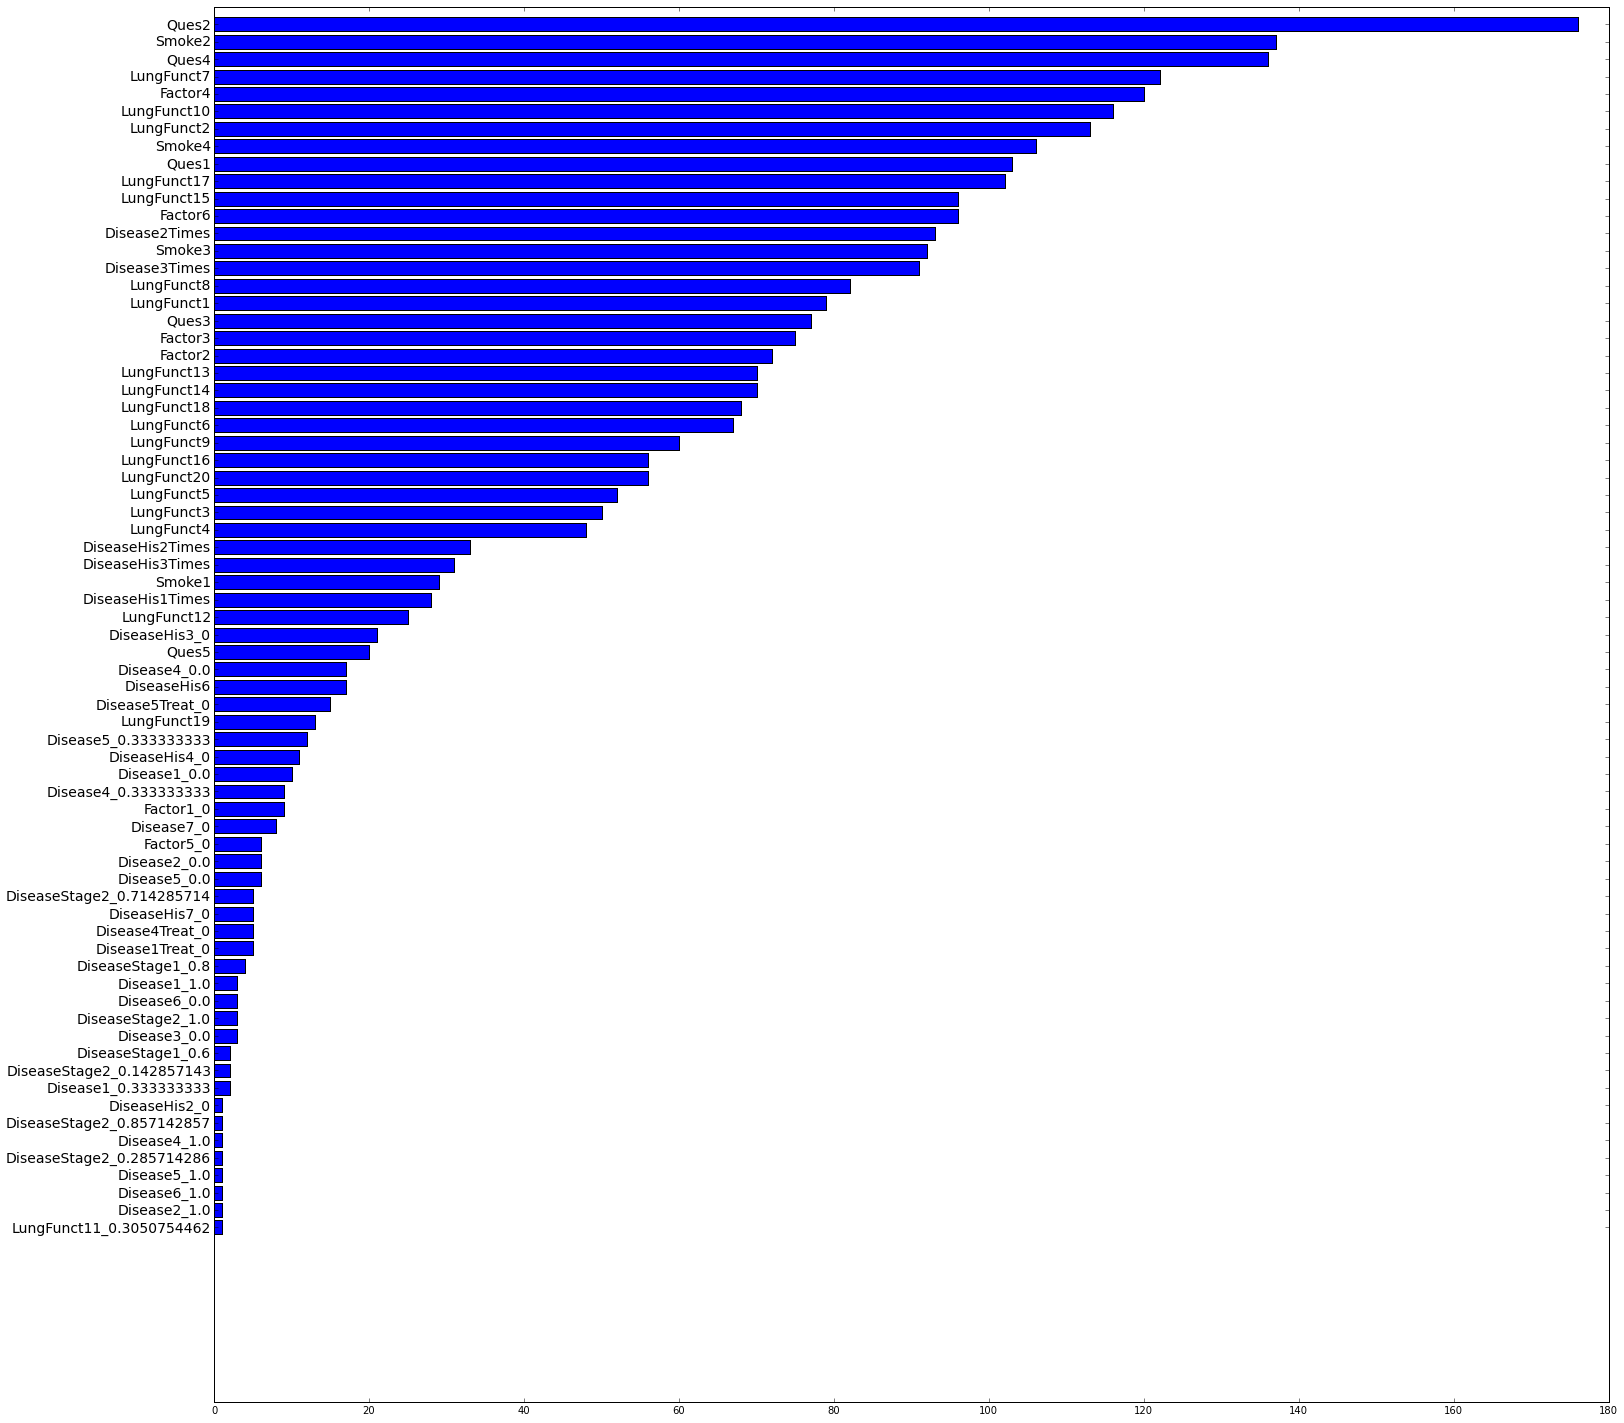

In [12]:
import xgboost as xgb
from collections import OrderedDict

# Check feature importances for the classifier.
xgb_params = {"objective": "binary:logistic","max_depth": 8}
num_rounds = 500
xg_train = xgb.DMatrix(features,label=labels)
bst = xgb.train(xgb_params, xg_train, num_rounds)
importances = bst.get_fscore()
importances = OrderedDict(sorted(importances.items(), key=lambda x: x[1]))

# Plot the importan features with fscore
plt.figure(figsize=(25,25))
plt.barh(range(len(importances)), importances.values(), align='center')
plt.yticks(range(len(importances)),importances.keys(),fontsize=14)
plt.show()

In [13]:
# Important Features
imp_features = features[importances.keys()[-40:]]
imp_test_features = test_features[importances.keys()[-40:]]
print imp_features.columns

Index([u'Disease5Treat_0', u'DiseaseHis6', u'Disease4_0.0', u'Ques5',
       u'DiseaseHis3_0', u'LungFunct12', u'DiseaseHis1Times', u'Smoke1',
       u'DiseaseHis3Times', u'DiseaseHis2Times', u'LungFunct4', u'LungFunct3',
       u'LungFunct5', u'LungFunct20', u'LungFunct16', u'LungFunct9',
       u'LungFunct6', u'LungFunct18', u'LungFunct14', u'LungFunct13',
       u'Factor2', u'Factor3', u'Ques3', u'LungFunct1', u'LungFunct8',
       u'Disease3Times', u'Smoke3', u'Disease2Times', u'Factor6',
       u'LungFunct15', u'LungFunct17', u'Ques1', u'Smoke4', u'LungFunct2',
       u'LungFunct10', u'Factor4', u'LungFunct7', u'Ques4', u'Smoke2',
       u'Ques2'],
      dtype='object')


In [14]:
# Parameter Tuning
from sklearn.cross_validation import *
from sklearn.metrics import *
from sklearn.grid_search import GridSearchCV
from pprint import pprint

# List of hyperparametres
xgb_model = xgb.XGBClassifier()

######################################################################
#   ADD MORE PARAMETERS WHEN VALIDATING FOR FINAL SUBMISSIONS
######################################################################
parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.01,0.1],
              'max_depth': [6,9],
              'min_child_weight': [5,8],
              'subsample': [0.6,0.75],
              'colsample_bytree': [0.75,0.9],
              'n_estimators': [10]
              }

# Grid Search using stratified K fold
clf = GridSearchCV(xgb_model,parameters,n_jobs=4,cv=StratifiedKFold(labels,n_folds=4, shuffle=True),
                   scoring='roc_auc',refit=True)
clf.fit(imp_features,labels)
best_parameters,score,filler = max(clf.grid_scores_,key=lambda x:x[1])

#Get Best hyper parameters
print "score:", score, "\n"
pprint(best_parameters)

score: 0.77846844117 

{'colsample_bytree': 0.75,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 8,
 'n_estimators': 10,
 'nthread': 4,
 'objective': 'binary:logistic',
 'subsample': 0.6}


In [15]:
d_train = xgb.DMatrix(imp_features, label=labels)
d_test = xgb.DMatrix(imp_test_features)

print imp_features.shape
print imp_test_features.shape
# Use best parameters from hyperparameter tuning
param = best_parameters
param['n_estimators'] = 100

bst = xgb.train(param,d_train)
pred = bst.predict(d_test) # Contains probabilities
pd.DataFrame(pred).to_csv("result",index=False)

pred_transformed = []
# Transform the probabilites to class labels.
for i in range(len(pred)) : 
    if pred[i] > 0.5 :
        pred_transformed.append(1)
    else :
        pred_transformed.append(0)

(1389, 40)
(596, 40)
